beamforming weights:  (1+0j) (2.83276944882399e-16-1j) (-1-5.66553889764798e-16j) (-1.0718754395722282e-15+1j)
[1.        +0.j         0.9921147 +0.12533323j 0.96858316+0.24868989j ...
 0.92977649-0.36812455j 0.96858316-0.24868989j 0.9921147 -0.12533323j]


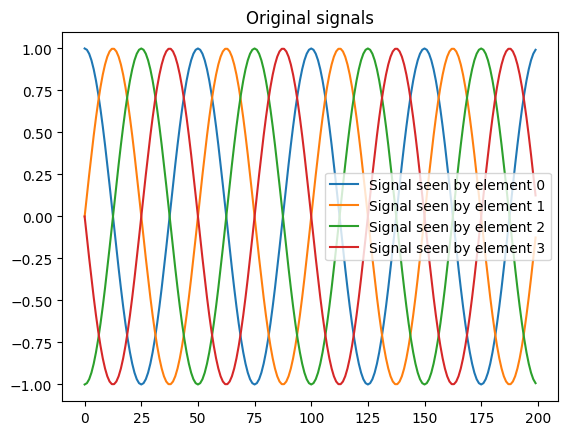

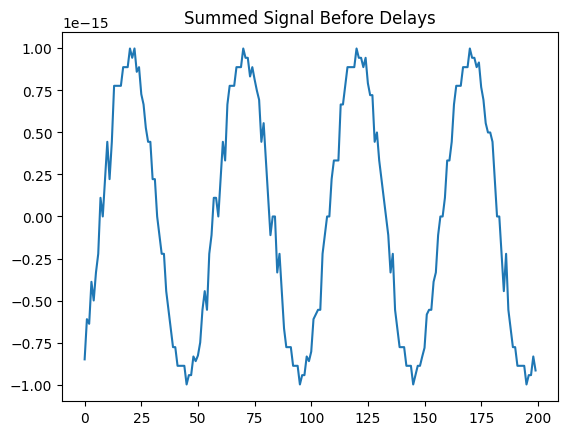

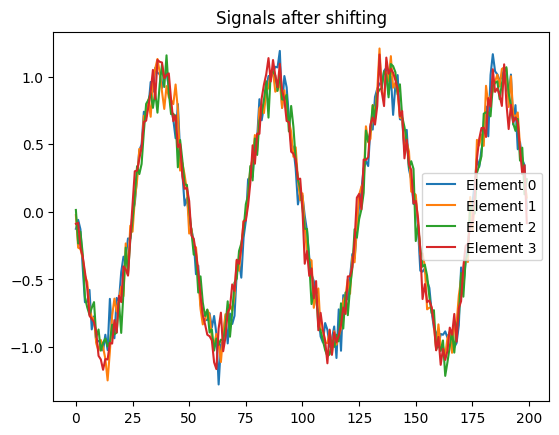

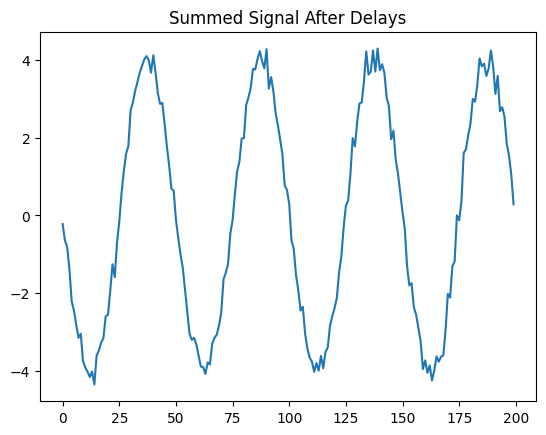

Average Error:  0.0416687050701885


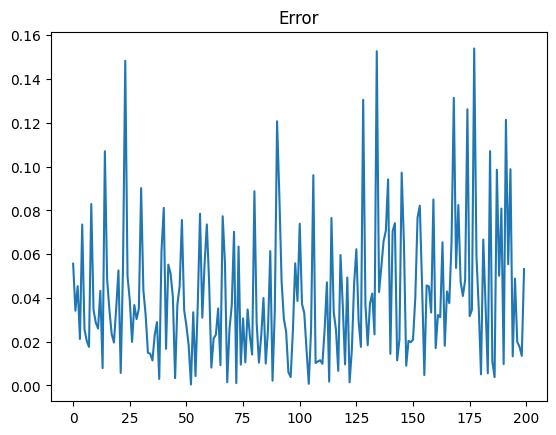

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import time

sample_rate = 1e6
N = 10000 # number of samples to simulate
d = 0.5 # half wavelength spacing
Nr = 4
theta_degrees = 30 # direction of arrival (feel free to change this, it's arbitrary)
theta = theta_degrees / 180 * np.pi # convert to radians

# Create 4 tones to simulate signals being seen by each element

t = np.arange(N)/sample_rate # time vector
shift = 50/4
f_tone = 0.02e6
tx = np.exp(2j * np.pi * f_tone * t)

b_0 = np.exp(-2j * np.pi * d * 0 * np.sin(theta)) # array factor
b_1 = np.exp(-2j * np.pi * d * 1 * np.sin(theta)) # array factor
b_2 = np.exp(-2j * np.pi * d * 2 * np.sin(theta)) # array factor
b_3 = np.exp(-2j * np.pi * d * 3 * np.sin(theta)) # array factor

print("beamforming weights: ", b_0, b_1, b_2, b_3)


tx_0 = tx * b_0
tx_1 = tx * b_1
tx_2 = tx * b_2
tx_3 = tx * b_3

print(tx_0)
# tx_0 = np.exp(2j * np.pi * f_tone * (t-(0*shift*(1/sample_rate))))
# tx_1 = np.exp(2j * np.pi * f_tone * (t-(1*shift*(1/sample_rate))))
# tx_2 = np.exp(2j * np.pi * f_tone * (t-(2*shift*(1/sample_rate))))
# tx_3 = np.exp(2j * np.pi * f_tone * (t-(3*shift*(1/sample_rate))))

# tx_list = [tx_0, tx_1, tx_2, tx_3]


plt.plot(np.asarray(tx_0).squeeze().real[0:200], label="Signal seen by element 0")
plt.plot(np.asarray(tx_1).squeeze().real[0:200], label="Signal seen by element 1")
plt.plot(np.asarray(tx_2).squeeze().real[0:200], label="Signal seen by element 2")
plt.plot(np.asarray(tx_3).squeeze().real[0:200], label="Signal seen by element 3")
plt.title("Original signals")
plt.legend()
plt.show()

r = []
r.append(b_3*tx_0)
r.append(b_2*tx_1)
r.append(b_1*tx_2)
r.append(b_0*tx_3)

# Introduce noise
n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
r = r + 0.1*n # r and n are both 3x10000

# Plot summed signals before delays
summed_signal = np.asarray(tx_0).squeeze().real[0:200] + np.asarray(tx_1).squeeze().real[0:200] + np.asarray(tx_2).squeeze().real[0:200] + np.asarray(tx_3).squeeze().real[0:200]
plt.plot(summed_signal, label="Summed")
plt.title("Summed Signal Before Delays")
plt.show()

plt.plot(np.asarray(r[0]).squeeze().real[0:200], label="Element 0")
plt.plot(np.asarray(r[1]).squeeze().real[0:200], label="Element 1")
plt.plot(np.asarray(r[2]).squeeze().real[0:200], label="Element 2")
plt.plot(np.asarray(r[3]).squeeze().real[0:200], label="Element 3")
plt.title("Signals after shifting")
plt.legend()
plt.show()

# Plot summed signal and original
summed_signal = np.asarray(r[0]).squeeze().real[0:200] + np.asarray(r[1]).squeeze().real[0:200] + np.asarray(r[2]).squeeze().real[0:200] + np.asarray(r[3]).squeeze().real[0:200]
plt.plot(summed_signal, label="Summed")
plt.title("Summed Signal After Delays")
plt.show()

# Plot error between received and original signal
plt.plot(abs((summed_signal/4) - np.asarray(tx_3).squeeze().real[0:200]))
print("Average Error: ", sum( abs((summed_signal/4) - np.asarray(tx_3).squeeze().real[0:200]) ) /200)
plt.title("Error")
plt.show()



a:  [ 1.00000000e+00+0.0000000e+00j  2.83276945e-16-1.0000000e+00j
 -1.00000000e+00-5.6655389e-16j -1.07187544e-15+1.0000000e+00j]
r.shape:  (4, 10000)
r:  [[ 1.00000000e+00+0.00000000e+00j  9.92114701e-01+1.25333234e-01j
   9.68583161e-01+2.48689887e-01j ...  9.29776486e-01-3.68124553e-01j
   9.68583161e-01-2.48689887e-01j  9.92114701e-01-1.25333234e-01j]
 [ 2.83276945e-16-1.00000000e+00j  1.25333234e-01-9.92114701e-01j
   2.48689887e-01-9.68583161e-01j ... -3.68124553e-01-9.29776486e-01j
  -2.48689887e-01-9.68583161e-01j -1.25333234e-01-9.92114701e-01j]
 [-1.00000000e+00-5.66553890e-16j -9.92114701e-01-1.25333234e-01j
  -9.68583161e-01-2.48689887e-01j ... -9.29776486e-01+3.68124553e-01j
  -9.68583161e-01+2.48689887e-01j -9.92114701e-01+1.25333234e-01j]
 [-1.07187544e-15+1.00000000e+00j -1.25333234e-01+9.92114701e-01j
  -2.48689887e-01+9.68583161e-01j ...  3.68124553e-01+9.29776486e-01j
   2.48689887e-01+9.68583161e-01j  1.25333234e-01+9.92114701e-01j]]


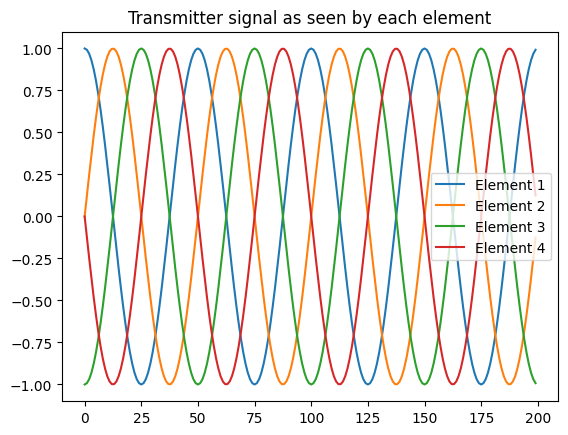

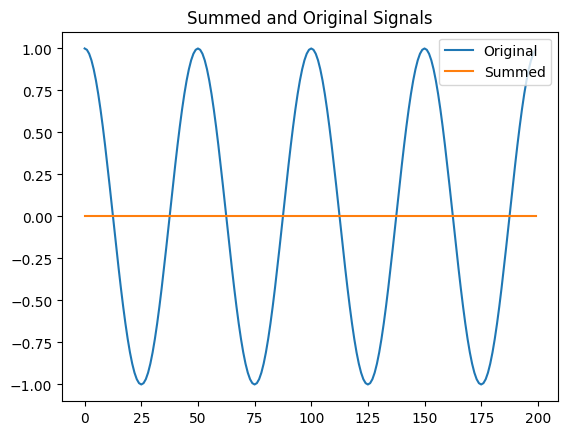

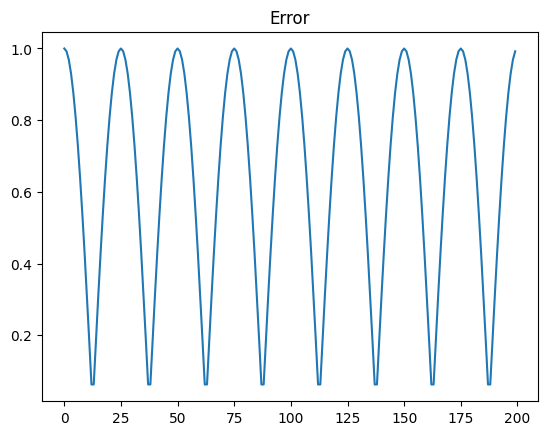

In [16]:
# # Create a tone to simulate a jammer
# f_jammer = 0.01e6
# tx_jammer= np.exp(2j * np.pi * f_jammer * t)

# plt.plot(np.asarray(tx_jammer).squeeze().real[0:200])
# plt.title("Jammer signal")
# plt.show()

# tx_combo = tx + tx_jammer
# plt.plot(np.asarray(tx_combo).squeeze().real[0:200])
# plt.title("Combined signal")
# plt.show()


d = 0.5 # half wavelength spacing
Nr = 4
theta_degrees = 30 # direction of arrival (feel free to change this, it's arbitrary)
theta = theta_degrees / 180 * np.pi # convert to radians
a = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta)) # array factor
print("a: ", a) # note that it's a 1xNr, it's complex, and the first element is 1+0j

a = np.asmatrix(a)
tx = np.asmatrix(tx)


r = a.T @ tx  # don't get too caught up by the transpose a, the important thing is we're multiplying the array factor by the tx signal
print("r.shape: ", r.shape) # r is now going to be a 2D array, 1D is time and 1D is the spatial dimension
print("r: ", r)

# Introduce noise
# n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
# r = r + 0.1*n # r and n are both 3x10000

# Plot each element's recieved signal separately
plt.plot(np.asarray(r[0,:]).squeeze().real[0:200], label="Element 1") # the asarray and squeeze are just annoyances we have to do because we came from a matrix
plt.plot(np.asarray(r[1,:]).squeeze().real[0:200], label="Element 2")
plt.plot(np.asarray(r[2,:]).squeeze().real[0:200], label="Element 3")
plt.plot(np.asarray(r[3,:]).squeeze().real[0:200], label="Element 4")
plt.legend()
plt.title("Transmitter signal as seen by each element")
plt.show()

# Plot summed signal and original
summed_signal = np.asarray(r[0,:]).squeeze().real[0:200] + np.asarray(r[1,:]).squeeze().real[0:200] + np.asarray(r[2,:]).squeeze().real[0:200] + np.asarray(r[3,:]).squeeze().real[0:200]
plt.plot(np.asarray(tx).squeeze().real[0:200], label="Original")
plt.plot(summed_signal, label="Summed")
plt.title("Summed and Original Signals")
plt.legend()
plt.show()


# Plot error between received and original signal
plt.plot(abs((summed_signal/4) - np.asarray(tx).squeeze().real[0:200]))
plt.title("Error")
plt.show()


a:  [ 1.00000000e+00+0.0000000e+00j  2.83276945e-16-1.0000000e+00j
 -1.00000000e+00-5.6655389e-16j -1.07187544e-15+1.0000000e+00j]
r.shape:  (4, 10000)
r:  [[ 1.00000000e+00+0.00000000e+00j  9.92114701e-01+1.25333234e-01j
   9.68583161e-01+2.48689887e-01j ...  9.29776486e-01-3.68124553e-01j
   9.68583161e-01-2.48689887e-01j  9.92114701e-01-1.25333234e-01j]
 [ 2.83276945e-16-1.00000000e+00j  1.25333234e-01-9.92114701e-01j
   2.48689887e-01-9.68583161e-01j ... -3.68124553e-01-9.29776486e-01j
  -2.48689887e-01-9.68583161e-01j -1.25333234e-01-9.92114701e-01j]
 [-1.00000000e+00-5.66553890e-16j -9.92114701e-01-1.25333234e-01j
  -9.68583161e-01-2.48689887e-01j ... -9.29776486e-01+3.68124553e-01j
  -9.68583161e-01+2.48689887e-01j -9.92114701e-01+1.25333234e-01j]
 [-1.07187544e-15+1.00000000e+00j -1.25333234e-01+9.92114701e-01j
  -2.48689887e-01+9.68583161e-01j ...  3.68124553e-01+9.29776486e-01j
   2.48689887e-01+9.68583161e-01j  1.25333234e-01+9.92114701e-01j]]


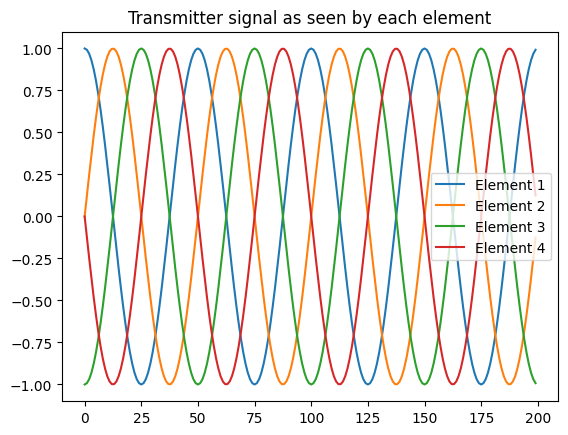

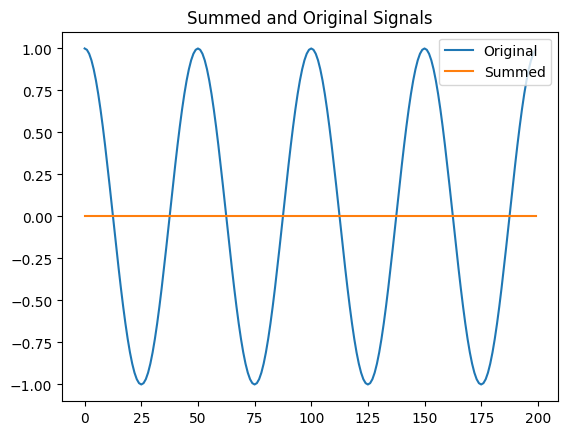

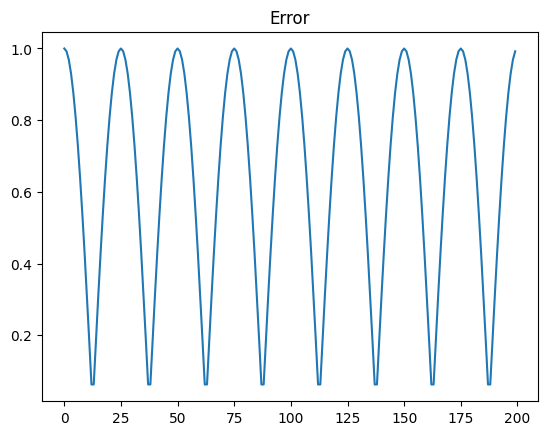

In [17]:
# # Create a tone to simulate a jammer
# f_jammer = 0.01e6
# tx_jammer= np.exp(2j * np.pi * f_jammer * t)

# plt.plot(np.asarray(tx_jammer).squeeze().real[0:200])
# plt.title("Jammer signal")
# plt.show()

# tx_combo = tx + tx_jammer
# plt.plot(np.asarray(tx_combo).squeeze().real[0:200])
# plt.title("Combined signal")
# plt.show()


d = 0.5 # half wavelength spacing
Nr = 4
theta_degrees = 30 # direction of arrival (feel free to change this, it's arbitrary)
theta = theta_degrees / 180 * np.pi # convert to radians
a = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta)) # array factor
print("a: ", a) # note that it's a 1xNr, it's complex, and the first element is 1+0j

a = np.asmatrix(a)
tx = np.asmatrix(tx)


r = a.T @ tx  # don't get too caught up by the transpose a, the important thing is we're multiplying the array factor by the tx signal
print("r.shape: ", r.shape) # r is now going to be a 2D array, 1D is time and 1D is the spatial dimension
print("r: ", r)

# Introduce noise
# n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
# r = r + 0.1*n # r and n are both 3x10000

# Plot each element's recieved signal separately
plt.plot(np.asarray(r[0,:]).squeeze().real[0:200], label="Element 1") # the asarray and squeeze are just annoyances we have to do because we came from a matrix
plt.plot(np.asarray(r[1,:]).squeeze().real[0:200], label="Element 2")
plt.plot(np.asarray(r[2,:]).squeeze().real[0:200], label="Element 3")
plt.plot(np.asarray(r[3,:]).squeeze().real[0:200], label="Element 4")
plt.legend()
plt.title("Transmitter signal as seen by each element")
plt.show()

# Plot summed signal and original
summed_signal = np.asarray(r[0,:]).squeeze().real[0:200] + np.asarray(r[1,:]).squeeze().real[0:200] + np.asarray(r[2,:]).squeeze().real[0:200] + np.asarray(r[3,:]).squeeze().real[0:200]
plt.plot(np.asarray(tx).squeeze().real[0:200], label="Original")
plt.plot(summed_signal, label="Summed")
plt.title("Summed and Original Signals")
plt.legend()
plt.show()


# Plot error between received and original signal
plt.plot(abs((summed_signal/4) - np.asarray(tx).squeeze().real[0:200]))
plt.title("Error")
plt.show()

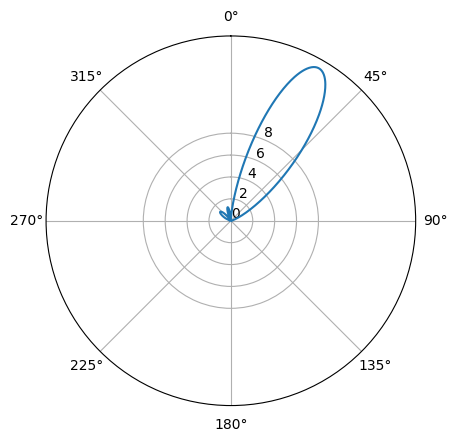

29.999999999999993


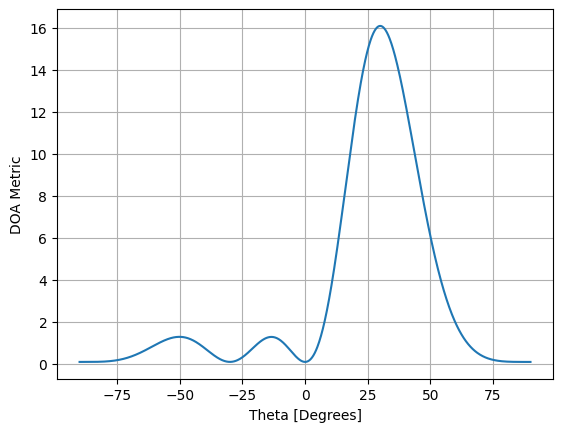

In [18]:
# DOA

theta_scan = np.linspace(-1*np.pi/2, np.pi/2, 1000) # 1000 different thetas between -180 and +180 degrees



for doa in range(30,31):

    results = []

    theta = doa / 180 * np.pi # convert to radians
    a = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta)) # array factor
    # print(a) # note that it's a 1x3, it's complex, and the first element is 1+0j

    a = np.asmatrix(a)
    tx = np.asmatrix(tx)

    r = a.T @ tx  # don't get too caught up by the transpose a, the important thing is we're multiplying the array factor by the tx signal
    # print(r.shape) # r is now going to be a 2D array, 1D is time and 1D is the spatial dimension

    # Introduce noise
    n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
    r = r + 0.1*n # r and n are both 3x10000

    for theta_i in theta_scan:
        #print(theta_i)
        w = np.asmatrix(np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta_i))) # look familiar?
        r_weighted = np.conj(w) @ r # apply our weights corresponding to the direction theta_i
        r_weighted = np.asarray(r_weighted).squeeze() # get it back to a normal 1d numpy array
        results.append(np.mean(np.abs(r_weighted)**2)) # energy detector
    
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.plot(theta_scan, results) # MAKE SURE TO USE RADIAN FOR POLAR
    ax.set_theta_zero_location('N') # make 0 degrees point up
    ax.set_theta_direction(-1) # increase clockwise
    ax.set_rgrids([0,2,4,6,8])
    ax.set_rlabel_position(22.5)  # Move grid labels away from other labels
    plt.show()


# print angle that gave us the max value
print(theta_scan[np.argmax(results)] * 180 / np.pi) # 19.99999999999998
plt.plot(theta_scan*180/np.pi, results) # lets plot angle in degrees
plt.xlabel("Theta [Degrees]")
plt.ylabel("DOA Metric")
plt.grid()
plt.show()

